In [1]:
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

C:\Users\chico\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[*********************100%***********************]  1 of 1 completed
train_size: 166
test_size: 82
Epoch 1/100
164/164 - 2s - loss: 0.0422 - 2s/epoch - 14ms/step
Epoch 2/100
164/164 - 0s - loss: 0.0079 - 317ms/epoch - 2ms/step
Epoch 3/100
164/164 - 0s - loss: 0.0062 - 310ms/epoch - 2ms/step
Epoch 4/100
164/164 - 0s - loss: 0.0046 - 309ms/epoch - 2ms/step
Epoch 5/100
164/164 - 0s - loss: 0.0032 - 318ms/epoch - 2ms/step
Epoch 6/100
164/164 - 0s - loss: 0.0023 - 312ms/epoch - 2ms/step
Epoch 7/100
164/164 - 0s - loss: 0.0016 - 350ms/epoch - 2ms/step
Epoch 8/100
164/164 - 0s - loss: 0.0012 - 336ms/epoch - 2ms/step
Epoch 9/100
164/164 - 0s - loss: 0.0010 - 343ms/epoch - 2ms/step
Epoch 10/100
164/164 - 0s - loss: 9.3073e-04 - 316ms/epoch - 2ms/step
Epoch 11/100
164/164 - 0s - loss: 8.7626e-04 - 309ms/epoch - 2ms/step
Epoch 12/100
164/164 - 0s - loss: 8.8236e-04 - 309ms/epoch - 2ms/step
Epoch 13/100
164/164 - 0s - loss: 8.7560e-04 - 347ms/epoch - 2ms/step
Epoch 14/100
164/164 - 0s - loss: 8.28

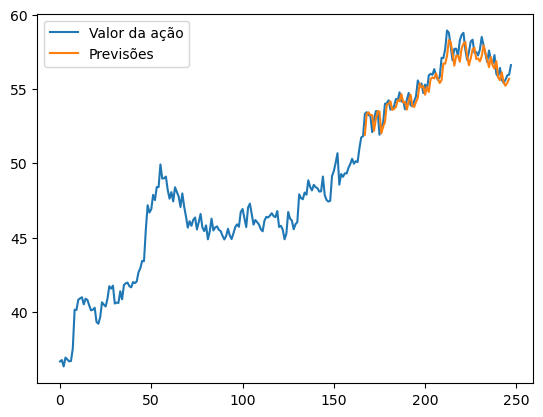


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 0.4665247548326075
Median Absolute Deviation (MAD): 0.4714794158935547
Mean Absolute Error (MAE): 0.5332862377166745
R-squared (R²): 0.8601289931307243


In [1]:
# Importação das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Fixação da semente aleatória para reproducibilidade
tf.random.set_seed(7)

# Importação de funções e constantes específicas
from functions.stock import download_stock_data
from const.interval import Interval

# Download dos dados de ações e organização em um DataFrame pandas
stock_data = download_stock_data("BBAS3.SA", Interval.DAY.value, 365)
dataset = pd.DataFrame({'Close': stock_data['Adj Close'].values}, index=range(len(stock_data)))

# Normalização dos dados para um intervalo específico
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Divisão dos dados em conjuntos de treinamento e teste
train_size = int(len(dataset) * 0.67)
print("train_size: " + str(train_size))
test_size = len(dataset) - train_size
print("test_size: " + str(test_size))
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Definição de uma função para preparar os dados para alimentar o modelo LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Redimensionamento dos dados para serem compatíveis com a entrada da rede LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Criação da arquitetura do modelo LSTM
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinamento do modelo com os dados de treinamento
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Realização de previsões tanto nos dados de treinamento quanto nos dados de teste
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inversão da normalização nas previsões para obter os valores na mesma escala que os dados originais
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Cálculo do erro médio quadrático (RMSE) nas previsões de treinamento e teste
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# Preparação dos dados para plotagem das previsões
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# Plotagem do gráfico com os dados originais e as previsões
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.legend(['Valor da ação', 'Previsões'], fontsize=10)
plt.show()

# Avaliação de desempenho das previsões usando métricas específicas
arr1 = np.array(scaler.inverse_transform(dataset))
arr2 = np.array(testPredictPlot)
valid_indices = ~np.isnan(arr2)
from functions.validation import performance_evaluation

test_performance = performance_evaluation(arr1[valid_indices], arr2[valid_indices])

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')